## Cellpose 3D with denoising 

This template was done in part to help with this [forum question](https://forum.image.sc/t/help-with-segmenting-cell-junctions-in-noisy-3d-images/106330)

To run you need an environment with cellpose 3.1.0 and the development version of tnia-python for some visualizations. 

```
pip install cellpose==3.1.0
pip install clij2-fft==0.
pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python.git 
```

In [4]:
from skimage.io import imread
import os
import numpy as np
from tnia.plotting.projections import show_xy_zy_max, show_xy_zy_slice_center
from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap, imshow2d
from tnia.plotting.projections import show_xy_zy_max
from tnia.plotting.plt_helper import create_rgb, imshow_multi2d, create_linear_napari_color_map, get_color
from tnia.plotting.plt_helper import random_label_cmap

## Get the image

You will have to ofcourse change the path

In [2]:
parent_path =r'D:\images\tnia-python-images\imagesc\2024_12_18_noisy_cellpose_3D'
im = imread(os.path.join(parent_path, r'Sample_data.tif'))
print(im.shape)

(7, 1024, 1024)


## Take a look at what we are dealing with...

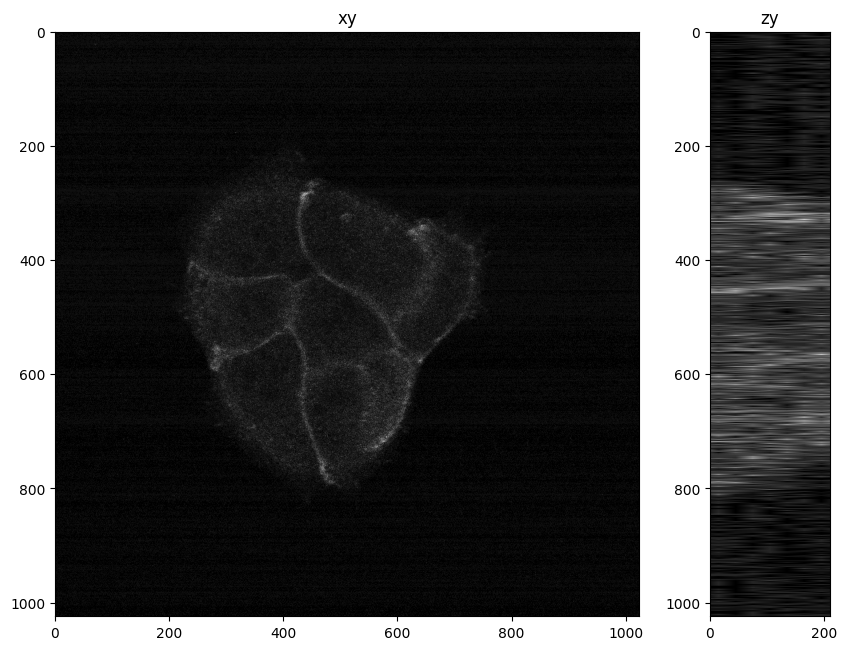

In [3]:
fig = show_xy_zy_slice_center(im,sz=30,figsize=(10,10), colormap='gray')

## Denoise with Cellpose

In [10]:
from cellpose import denoise
diameter = 120
dn = denoise.DenoiseModel(model_type="denoise_cyto3", gpu=True)

In [23]:
imgs_dn = dn.eval(im, do_3D=True, channels=None, diameter=diameter)
imgs_dn = np.squeeze(imgs_dn)

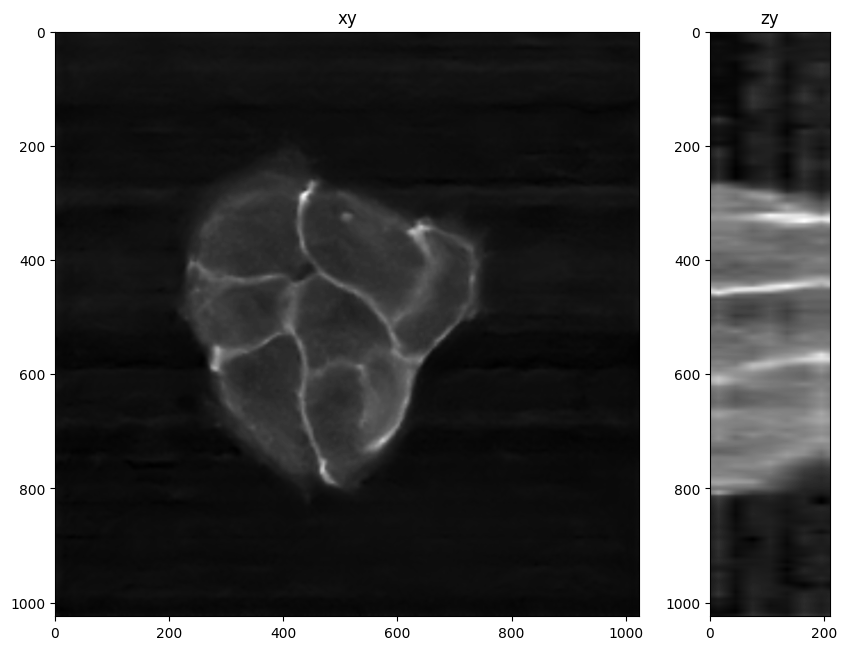

In [24]:
fig = show_xy_zy_slice_center(imgs_dn,sz=30,figsize=(10,10), colormap='gray')

## Try Cellpose 3D

(Did not work in my hands)

In [25]:
from cellpose import models
mod = models.Cellpose(gpu=True, model_type="cyto3")


In [46]:
mask3D = mod.eval(imgs_dn, diameter=diameter, anisotropy=3,  do_3D=True, niter=200, dP_smooth=3, cellprob_threshold=0)[0]

z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


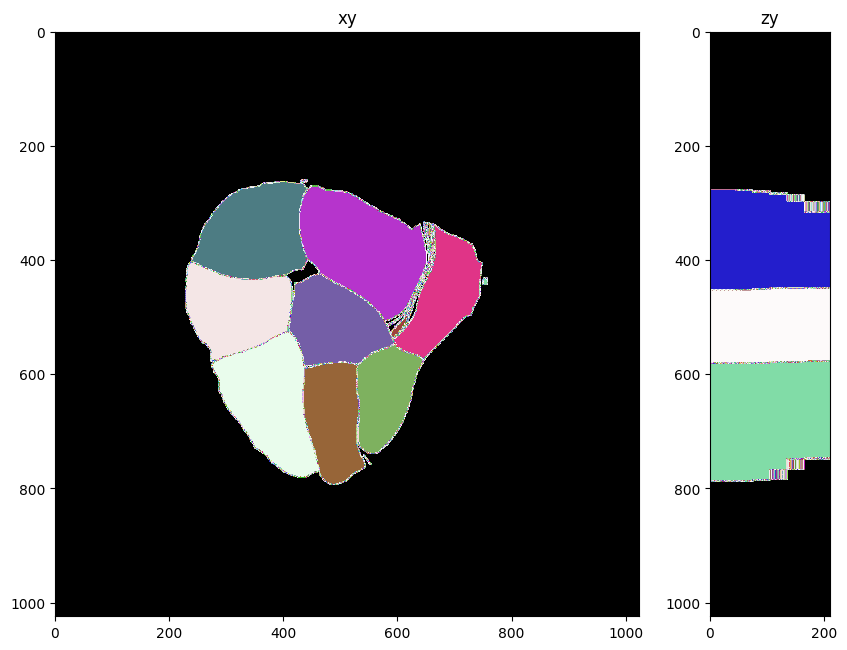

In [47]:
fig = show_xy_zy_slice_center(mask3D,sz=30,figsize=(10,10), colormap=random_label_cmap())

## Try Cellpose 2D on each slice and 'Connect-in-3D' 

This seems to work 

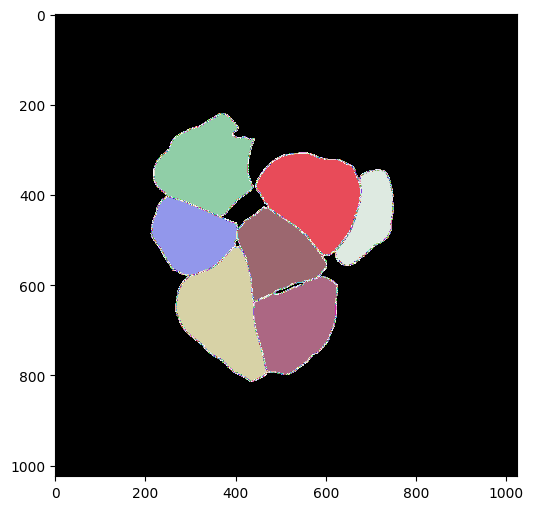

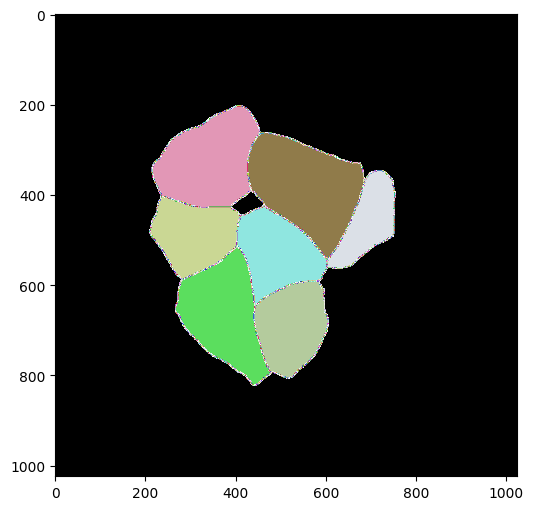

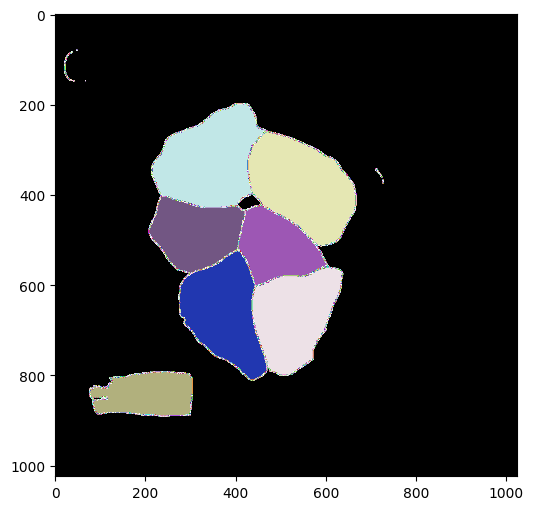

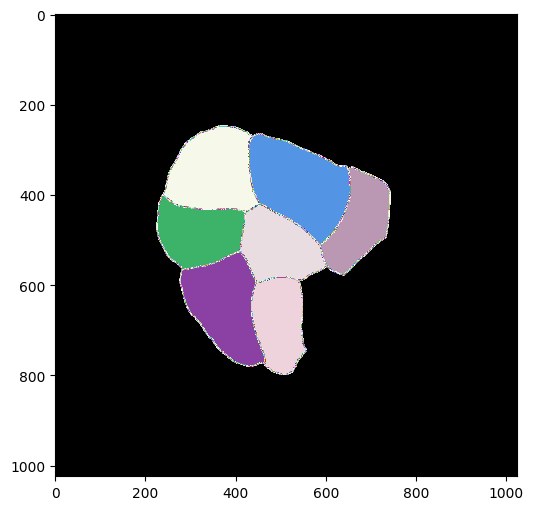

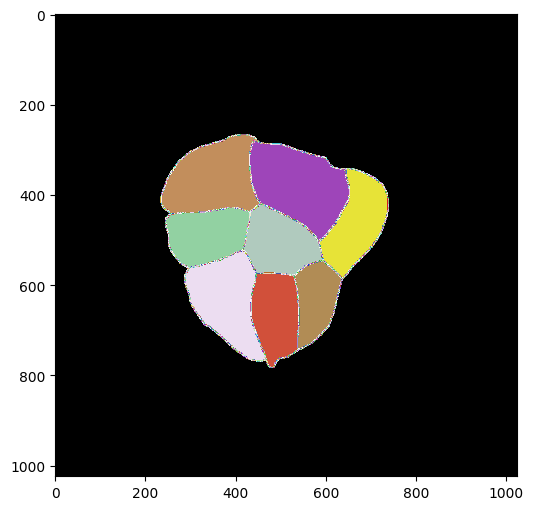

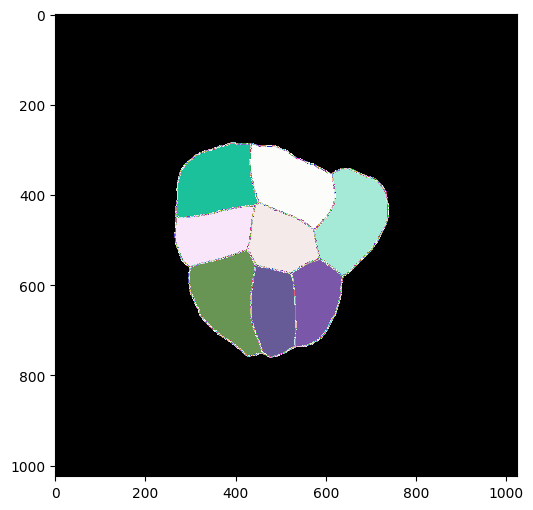

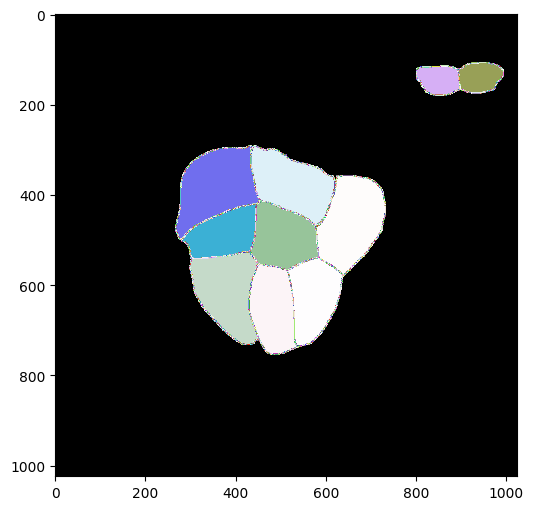

In [48]:
masks_2D = []

for i in range(mask3D.shape[0]):
    maskk_2D = mod.eval(imgs_dn[i,...], diameter=80, niter=200, dP_smooth=5)[0]
    fig = imshow2d(maskk_2D, colormap=random_label_cmap())
    masks_2D.append(maskk_2D)

In [49]:
from tnia.morphology.connect import connect_2d_in_3d

mask3D_connected = connect_2d_in_3d(np.array(masks_2D), threshold=50)

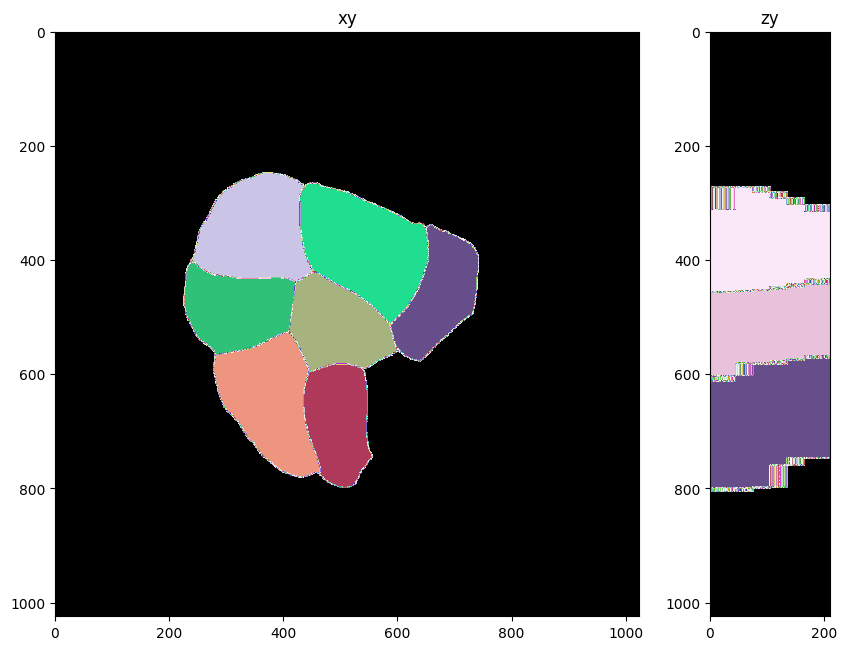

In [50]:
fig = show_xy_zy_slice_center(mask3D_connected,sz=30,figsize=(10,10), colormap=random_label_cmap())

In [51]:
import napari

viewer = napari.Viewer()


viewer.add_image(im, name='raw')
viewer.add_image(imgs_dn, name='denoised')
viewer.add_labels(mask3D, name='cellpose')
viewer.add_labels(np.array(masks_2D), name='cellpose 2D connect in 3D')

<Labels layer 'cellpose 2D connect in 3D' at 0x23945e34040>

In [57]:
test = np.array(masks_2D)
test.shape, im.shape, imgs_dn.shape, mask3D.shape

((7, 1024, 1024), (7, 1024, 1024), (7, 1024, 1024, 1), (7, 1024, 1024))